# Pipeline for tracking worms from a live video feed

In [0]:
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
import os
import cv2 
from PIL import Image
from tqdm.notebook import tqdm
import numpy as np
from numpy import moveaxis
from IPython.display import clear_output
import matplotlib.pyplot as plt
# import pandas as pd
import shutil
import random 
plt.rcParams["figure.figsize"] = (10,10)

ROOT = "/content/drive/My Drive/"

# Step 1: Trimming the video 
* The terminal commands below compresses the folder tree from google drive and copies and extracts them into the runtime 
>* `-C my_directory` tells tar to change the current directory to `my_directory`, and then `.` means "add the entire current directory" (including hidden files and sub-directories).
> * `v` in `-xvf` refers to verbose, it'll print all the names of the files which are being extracted.
* `trim_video()` takes in the input and output filename as the arguments, which work fine, but if the slip to be extracted is too short it returns an error in form of -1 frames

In [0]:
!tar -czf work_data.tar.gz -C /content/drive/"My Drive"/work_data .
!mkdir work_data
!tar -xvf  /content/work_data.tar.gz -C /content/work_data .
clear_output()

In [0]:
def trim_video(source_path, start_time, end_time, target_path):
    ffmpeg_extract_subclip(source_path, start_time, end_time, targetname=target_path)

In [4]:
source_path = "work_data/video/c_elegans_movement.mp4"
target_path = "work_data/trimmed/first_five_seconds.mp4"

trim_video(
    source_path = source_path, 
    start_time =29, 
    end_time =  32, 
    target_path = target_path)


[MoviePy] Running:
>>> /usr/bin/ffmpeg -y -i work_data/video/c_elegans_movement.mp4 -ss 29.00 -t 3.00 -vcodec copy -acodec copy work_data/trimmed/first_five_seconds.mp4
... command successful.


# Step 2: Extracting frames from the videos
* `video_to_frames(video_path, new_folder_path)` converts all the frames of a specified video file and saves it into a folder as .jpg files 

In [0]:
def video_to_frames(video_path, new_folder_path):
    frames_paths = []
    try:
        os.mkdir(new_folder_path)
    except:
        shutil.rmtree(new_folder_path)
        os.mkdir(new_folder_path) 
    vidObj = cv2.VideoCapture(video_path)   
    success = 1
    count = 0
    while success: 
        success, image = vidObj.read() 
        fmt_name = new_folder_path + "/" + str(count)+ ".jpg"
        try:
            cv2.imwrite(fmt_name, image)
            frames_paths.append(fmt_name)
            count += 1
        except:
            pass 
    print ("saved ", count-1, " frames at ", new_folder_path)
    return frames_paths

In [8]:
frames_folder = "work_data/trimmed/frames"
frames_paths = video_to_frames(
                                video_path = target_path,
                                new_folder_path = frames_folder
                               )

saved  60  frames at  work_data/trimmed/frames


## Some cv2 utilities

* `read_and_shrink_image(image_path, shrink_factor = 2)` reads the image in grayscale from the path and shrinks it by a factor of `shrink_factor**2`
* `draw_circle` and `draw_rectangle` draws circles and rectangles respectively

In [0]:
def read_and_shrink_image(image_path, shrink_factor = 2):
    raw_img = cv2.imread(image_path, 0) ## 0 means grayscale = 1 color channel 
    raw_img_small = cv2.resize(raw_img, (int(raw_img.shape[1]/shrink_factor), int(raw_img.shape[0]/shrink_factor)))
    return raw_img_small


def draw_circle(image, vertex, radius):
    with_circle = cv2.circle(100%
                            image,                
                            vertex, 
                            radius = radius, 
                            color = (0, 100, 255) , 
                            thickness = 2)
    return with_circle


def draw_rectangle(image, vertex1, vertex2):
    image = cv2.rectangle(image,
                    vertex1,
                    vertex2,
                    color=(0, 255, 0), thickness=3)
    return image

# Step 3: Testing out the pipeline on a single image
* First we blur the image by a small amount using `cv2.blur(image, kernel_size)` in order to remove noise and grain. A larger kernel size leads to a larger blur factor
* `kernel_size = (x,y)` - `x` and `y` define the horizontal and the vertical sizes of the kernel. Higher the `x`, higher the horizontal blur. Same goes for `y`

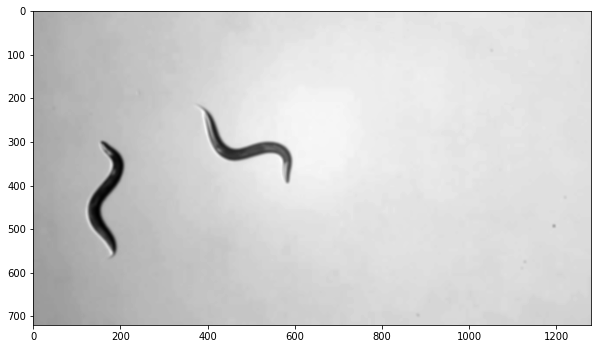

In [54]:
sample_image = cv2.imread(frames_folder+ "/" + "10.jpg", 0)
sample_image = cv2.blur(sample_image,(7,7)) 
plt.imshow(sample_image, cmap = "gray")
plt.show()

## Thresholding the image to extract the dark areas, i.e the worms 
* `cv2.threshold(sample_image, lower_threshold , new_value ,cv2.THRESH_BINARY)` - it converts all the pixel values **above** the `lower_threshold` to the `new_value` which is 255 (white).
* `cv2.THRESH_BINARY_INV` converts all the pixel values **below** the `lower_threshold` to the `new_value` which is 255 (white).

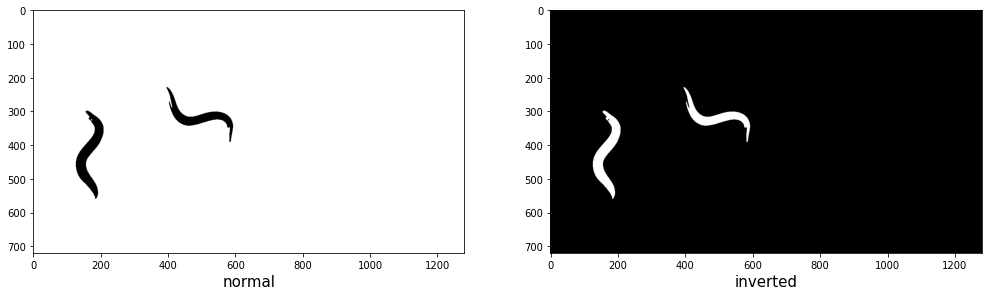

In [55]:
ret,thresh1 = cv2.threshold(sample_image,100, 255,cv2.THRESH_BINARY)
ret,thresh1_inv = cv2.threshold(sample_image,100, 255,cv2.THRESH_BINARY_INV)

fig, ax = plt.subplots(1,2, figsize = (17,5))
ax[0].imshow(thresh1, cmap = "gray")
ax[0].set_xlabel("normal", fontsize= 15)
ax[1].imshow(thresh1_inv, cmap = "gray")
ax[1].set_xlabel("inverted", fontsize= 15)
fig.show()

# Step 4: Detecting the worms 

* `threshold_image_np(raw_img, upper_gray_threshold, invert = True)` takes in the raw image in the form of a 2D numpy array and returns the thresholded image (see `cv2.threshold()` explained above ). Set `invert = False` to get the normal thresholded image, but in our case, an inverted thresholding is required.
* `find_worms_return_vertices(thresh_image, minimum_size, padding)` has three arguments as follows:
> * `thresh_image` = thresholded input image
> * `minimum_size` = minimum size of the objects to be detected, this is done so that the pipeline doesn't detect any small noisy points in the frame
> * `padding` makes sure that the whole worm is within the bounding rectangle

In [0]:
def threshold_image_np(raw_img, upper_gray_threshold, invert = True):  ## converts all pixels above upper_gray_threshold to 255 = white 
    
    if invert == True:
        ret,thresh1 = cv2.threshold(raw_img ,upper_gray_threshold,  255, cv2.THRESH_BINARY_INV)
    else:
        ret,thresh1 = cv2.threshold(raw_img ,upper_gray_threshold,  255, cv2.THRESH_BINARY)
    return thresh1


def find_worms_return_vertices(thresh_image, minimum_size = 50, padding = 20):

    rect_vertices = []
    contours, hierarchy = cv2.findContours(thresh_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        (x, y, w, h) = cv2.boundingRect(contour)
        if 0 in (x,y,w,h): ## skip invali stuff 
            continue
        if w < minimum_size or h < minimum_size :  # skip if too small to be a worm
            continue
        w += padding 
        h+= padding 
        rect_vertices.append([(x - padding , y - padding ), (x+w, y+h)])
    return rect_vertices

def draw_rectangle(image, vertex1, vertex2):
    image = cv2.rectangle(image,
                    vertex1,
                    vertex2,
                    color=(0, 255, 0), thickness=3)
    return image

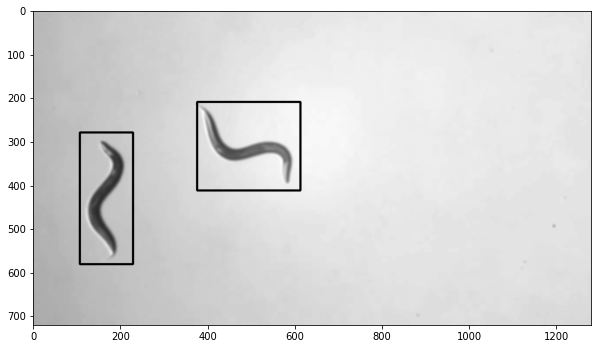

In [57]:
vertices = find_worms_return_vertices(thresh1_inv, minimum_size = 50, padding = 20)

for vertex in vertices:
    raw_img_rect = draw_rectangle(sample_image, vertex[0], vertex[1])

plt.rcParams["figure.figsize"] = (10,10)
plt.imshow(sample_image, cmap = "gray")
plt.show()


# Step 5: Extracting the segmented worm

* `extract_segmented_worm_and_save(real_img, thresh_img_inv, vertices, save_folder)` has the following steps:
> * The real and the thresholded images are cropped and saved in form of pairs
> * We then apply a bitwise AND using `cv2.bitwise_and()`on the thresholded image and the real image, which returns the real image with the background blacked out.

In [0]:
def extract_segmented_worm_and_save(real_img, thresh_img_inv, vertices, save_folder):

    cropped_image_pairs = []
    segmented_images = []

    for vertex in vertices:
        x1 = vertex[0][0]
        x2 = vertex[1][0]
        y1 = vertex[0][1]
        y2 = vertex[1][1]

        thresh_crop = thresh_img_inv[ y1:y2, x1:x2]
        real_crop = real_img[ y1:y2, x1:x2]
        cropped_image_pairs.append([thresh_crop,real_crop])

    for i in cropped_image_pairs:
        seg = cv2.bitwise_and(i[0],i[1], mask = None) 
        segmented_images.append(seg)

    for i in segmented_images:
        image_name = str(random.randint(0, 9999)) + "_" + str(random.randint(0, 9999)) + ".jpg"
        full_name = save_folder + "/" + image_name
        # plt.imshow(i, cmap = "gray")
        # plt.show()
        try:
            cv2.imwrite(full_name, i)
        except:
            print ("encountered an error while saving segmented image, skipping...")

### Viewing the segmented images 

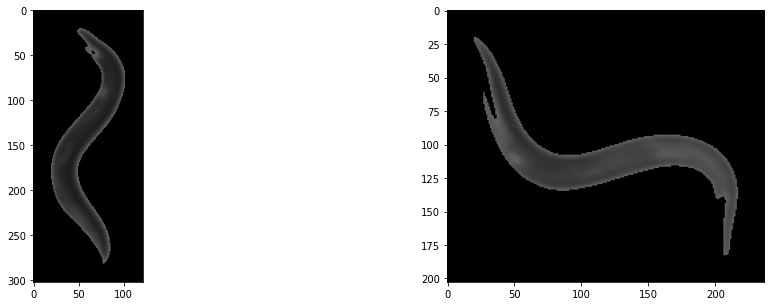

In [58]:
shutil.rmtree("sample_images")
os.mkdir("sample_images")
extract_segmented_worm_and_save(real_img = sample_image, thresh_img_inv = thresh1_inv, vertices = vertices, save_folder = "sample_images")

fig, ax = plt.subplots(1, len(os.listdir("sample_images")), figsize = (17,5))

for i in range (len(os.listdir("sample_images"))):
    ax[i].imshow(cv2.imread( "sample_images/" + os.listdir("sample_images")[i]))
    

## And it all comes together here 
* The reults are stored in 2 forms:
> * `rects_save_folder` contains all the frames of the video feed with rectagles drawn around the worms, they can be used to recreate the video again, this time with the tracking 
> * `seg_folder` contains the cropped and segmented images of the worms.

* Try increasing the `shrink_factor` if the computing power is limited. A shrink factor of `s` decreases the image size by `s**2`
 Feel free to change the folder names as per required.

In [0]:
rects_save_folder = "work_data/trimmed/rects"

seg_folder = ROOT + "segmented_worm_images"

try:  ## try to create new folders, if it fails, forcefully create them
    os.mkdir(rects_save_folder)
    os.mkdir(seg_folder)

except:
    shutil.rmtree(rects_save_folder)
    shutil.rmtree(seg_folder)

    os.mkdir(seg_folder)
    os.mkdir(rects_save_folder)

imcount = 0
for i in tqdm(frames_paths):
    
    image_path = i
    save_name = rects_save_folder + "/"+ str(imcount) + ".jpg"
    
    try:
        raw_img_small = read_and_shrink_image(image_path, shrink_factor = 3)
        raw_img_small = cv2.blur(raw_img_small,(7,7)) 
    except:
        continue
         
    thresh = threshold_image_np(raw_img_small, upper_gray_threshold = 120, invert = True)
    vertices = find_worms_return_vertices(thresh, minimum_size = 30, padding = 11)
  
    for vertex in vertices:

        raw_img_rect = draw_rectangle(raw_img_small, vertex[0], vertex[1])
        
    raw_img_color = cv2.applyColorMap( raw_img_rect , colormap = cv2.COLORMAP_JET)
        
    cv2.imwrite( save_name, raw_img_color)
    extract_segmented_worm_and_save(real_img = raw_img_small, thresh_img_inv = thresh, vertices = vertices, save_folder = seg_folder)
    
    imcount += 1
clear_output()

## Creating a GIF which visualises the tracking

In [0]:
from PIL import Image 

gif_name = "tracking.gif"

rect_save_paths = [rects_save_folder + "/" + str(i) + ".jpg" for i in range (imcount)]
images = []
for n in rect_save_paths:
    frame = Image.open(n)
    images.append(frame)

images[0].save(gif_name,
               save_all=True,
               append_images=images[1:350],
               duration=1,
               loop=0)
